![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

## Destination Earth - ERA5 hourly data on single levels from 1940 to present - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Documentation ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels)


<br>Author: EUMETSAT</br>

Credit: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example.</br>

## Obtain Authentication Token

In [1]:
import requests
import json
import os
from getpass import getpass
import destinelab as deauth

### Query using the DEDL HDA API


First, we get an access token for the API

In [2]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


## Filter
We have to setup up a filter and define which data to obtain.

[Filter Options HDA](https://hda.dedl.csgroup.space/stac/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/queryables?provider=copernicus_climate_data_store)

In [3]:
datechoice = "2020-06-10T10:00:00Z"
filters = {
    key: {"eq": value}
    for key, value in {
        "format": "grib",
        "variable": "2m_temperature",
        "time": "12:00"
    }.items()
}

In [4]:
## Make Data Request

In [7]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
 "collections": ["EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS"],
    "datetime": datechoice,
    "query": filters
})

# Requests to EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS first product 
#print(response.json())
product = response.json()["features"][0]
#product

## Once our product found, we download the data.

In [8]:
from IPython.display import JSON


# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
print(download_url)
HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = requests.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
else:
    JSON(response.json(), expanded=True)

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.REANALYSIS_ERA5_SINGLE_LEVELS/items/ERA5_SL_20200610_20200610_31cd08297c9c7a8b678700bde8c9760a5a235b30/download?provider=copernicus_climate_data_store&_dc_qs=%257B%2522date%2522%253A%252B%25222020-06-10%2F2020-06-10%2522%252C%252B%2522format%2522%253A%252B%2522grib%2522%252C%252B%2522product_type%2522%253A%252B%2522reanalysis%2522%252C%252B%2522time%2522%253A%252B%252212%253A00%2522%252C%252B%2522variable%2522%253A%252B%25222m_temperature%2522%257D


If the data is already available in the cache we can directly download it.
If the data is not available, we can see that our request is in `queued`status.  
We will then poll the API until the data is ready and then download it.

In [9]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)
        response.raise_for_status()

filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
downloading adaptor.mars.internal-1716307754.943054-6962-13-d2c1a700-b20d-47e1-8994-492b3f1198b3.grib


100%|██████████| 2.08M/2.08M [00:04<00:00, 431kB/s] 


## EarthKit

Lets plot the result file
[EarthKit Documentation] https://earthkit-data.readthedocs.io/en/latest/index.html

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [13]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

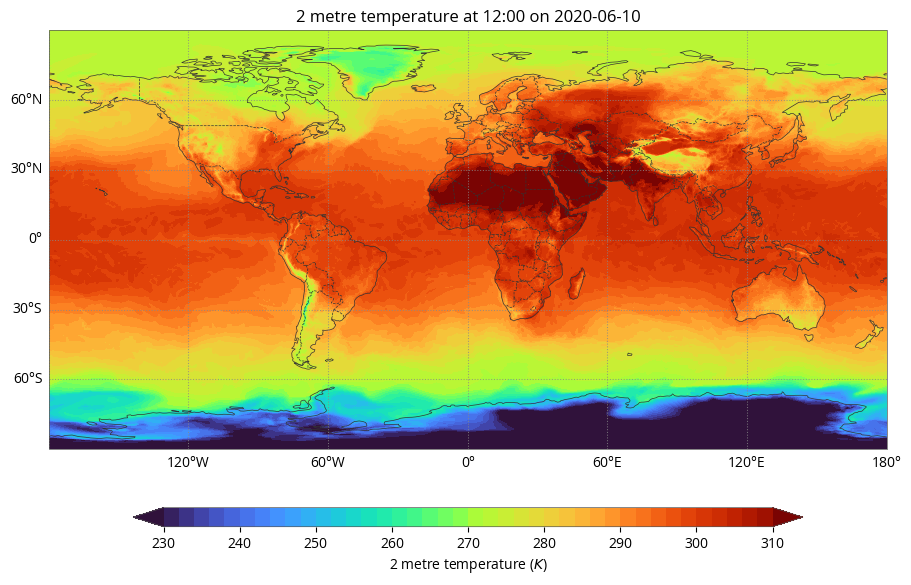

In [14]:
data = earthkit.data.from_source("file", filename)
data.ls
earthkit.maps.quickplot(data,#style=style
                       )